# Score prospects in real time using Snowplow Signals and machine learning


Welcome to the [Snowplow Signals](https://docs.snowplow.io/docs/signals/) real-time prospect scoring [tutorial](https://docs.snowplow.io/tutorials/signals-ml-prospect-scoring/intro).

This notebook is intended to be used as part of the tutorial. It's hosted in Google Colab so you won't need to configure anything locally.

Check out the tutorial pages to follow along.

## Set up the notebook

This notebook uses Signals Sandbox connection. If you use Signals in the Console uncomment relevant lines.

Add your credentials to the Colab notebook secrets. Or just replace these variable values.

In [1]:
from google.colab import userdata

# Signals Sandbox
SP_SANDBOX_URL = userdata.get('SP_SANDBOX_URL')     # https://{{123abc}}.svc.snplow.net
SP_SANDBOX_TOKEN = userdata.get('SP_SANDBOX_TOKEN') # 12345678-0000-1111-2222-123456789012

# Uncomment for Signals in the Console
# SP_API_URL = userdata.get('SP_API_URL')       # Signals API URL
# SP_API_KEY = userdata.get('SP_API_KEY')       # Signals API key
# SP_API_KEY_ID = userdata.get('SP_API_KEY_ID') # Signals API key ID
# SP_ORG_ID = userdata.get('SP_ORG_ID')         # Snowplow org ID

## Install notebook dependencies

In [2]:
%pip install snowplow-signals

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 21.9 MB/s eta 0:00:00


### Connect to Signals

In [3]:
from snowplow_signals import Signals, SignalsSandbox, Event
from datetime import timedelta

sp_signals = SignalsSandbox(
    api_url=SP_SANDBOX_URL,
    sandbox_token=SP_SANDBOX_TOKEN,
)

# Uncomment if you use Signals in the Console
# sp_signals = Signals(
#     api_url=SP_API_URL,
#     api_key=SP_API_KEY,
#     api_key_id=SP_API_KEY_ID,
#     org_id=SP_ORG_ID
# )

### Define attributes

In [4]:
from snowplow_signals import Attribute, Criteria, Criterion, AtomicProperty, EntityProperty

# Define an event
sp_page_view = Event(
    vendor="com.snowplowanalytics.snowplow",
    name="page_view",
    version="1-0-0"
)

# Define attributes
num_page_views = Attribute(
    name="num_page_views",
    type="int32",
    events=[sp_page_view],
    aggregation="counter"
)

num_pricing_views = Attribute(
    name="num_pricing_views",
    type="int32",
    events=[sp_page_view],
    aggregation="counter",
    criteria=Criteria(
        all=[
            Criterion.like(
                AtomicProperty(name="page_url"),
                "%pricing%"
            )
        ]
    )
)

num_customers_views = Attribute(
    name="num_customers_views",
    type="int32",
    events=[sp_page_view],
    aggregation="counter",
    criteria=Criteria(
        all=[
            Criterion.like(
                AtomicProperty(name="page_url"),
                "%customers%"
            )
        ]
    )
)

### Define an attribute group and a service

In [5]:
from snowplow_signals import StreamAttributeGroup, domain_userid, Service

user_attributes_group = StreamAttributeGroup(
    name='prospect_scoring_tutorial',
    owner='your_email@example.com',
    version=1,
    attribute_key=domain_userid,
    attributes=[
        num_page_views,
        num_pricing_views,
        num_customers_views,
    ],
)

prospect_scoring_tutorial_service = Service(
    name='prospect_scoring_tutorial_service',
    owner='your_email@example.com',
    attribute_groups=[user_attributes_group],
)

**Note:** if you're using Signals in the Console, you can test attributes on the last 1 hour of data like this:

```python
sp_signals.test(attribute_group=user_attributes_group, app_ids=["website"])
```

### Deploy configuration to Signals

Running this cell will connect to your Signals instance. Signals will start calculating attributes to populate your Profiles Store.

In [8]:
published = sp_signals.publish([user_attributes_group, prospect_scoring_tutorial_service])

# This should print "2 objects published"
print(f"{len(published)} objects published")

2 objects published


**Note:** you can't publish the same version of the attribute group or service a couple times. You will need to increase the version number or unpublish+delete the existing versions. You can use the code below during the tutorial to reset the attribute group and service after publishing them.


```python
sp_signals.unpublish([prospect_scoring_tutorial_service])
sp_signals.unpublish([user_attributes_group])
sp_signals.delete([prospect_scoring_tutorial_service])
sp_signals.delete([user_attributes_group])
```

### Look at your attributes

Use the Snowplow Inspector browser plugin to find your current `domain_userid`.

In [9]:
sp_signals_result = sp_signals.get_service_attributes(
    name="prospect_scoring_tutorial_service",
    attribute_key="domain_userid",
    identifier="00000000-1111-2222-3333-444455556666", # UPDATE THIS
)
sp_signals_result

{'domain_userid': '00000000-1111-2222-3333-444455556666',
 'num_page_views': None,
 'num_pricing_views': None,
 'num_customers_views': None}

## Train the ML prospect scoring model

### Prepare historical dataset

The code in this cell uses a sample of the Snowplow atomic table in a CSV format. Update this cell to connect to your warehouse and train on your own data. Duckdb SQL syntax is easily translatable to the common warehouses.

In [10]:
csv_filename = 'https://github.com/snowplow-incubator/signals-notebooks/raw/refs/heads/main/web/sample_events.csv.gz'

query = f"""
	with
	-- Change to your events table
	events as (
	    select * from read_csv_auto('{csv_filename}')
	    where app_id = 'website' -- filter for your app_ids
	        and domain_userid is not null -- filter to traffic with domain_userids
	        and event_name in ('page_view', 'submit_form') -- filter the events you need
	        -- and derived_tstamp >= dateadd('day', -90, current_date) -- filter by time
	        -- filter out bots, new/returning users, etc
	),
	-- Filter out post-conversion events
	post_conv as (
		select
			domain_userid,
			min(derived_tstamp) as first_conv
		from events
		where event_name = 'submit_form'
		group by 1
	),
	-- Prepare the target column
	targets_as_of_event as (
	    -- Target: will this person 'submit_form' in the next 1 hour?
	    select
	        -- identifiers
	        er.event_id,
	        -- target
	        count_if(ef.event_name = 'submit_form') > 0 as target_had_submit_form_next1h,
	    from events er
	    left join events ef on er.domain_userid = ef.domain_userid
	        and er.derived_tstamp < ef.derived_tstamp -- only future events
	        and datediff('second', er.derived_tstamp, ef.derived_tstamp) <= 60 * 60 -- only the next 1h of events
	    group by er.event_id
	),
	-- Prepare training features and dataset
	final_training as (
	    select
			    er.domain_userid,
	        er.derived_tstamp,
	        er.event_name,
	        coalesce(count_if(eh.event_name = 'page_view'), 0) as num_page_views,
	        coalesce(count_if(eh.event_name = 'page_view' and eh.page_url like '%pricing%'), 0) as num_pricing_views,
	        coalesce(count_if(eh.event_name = 'page_view' and eh.page_url like '%customers%'), 0) as num_customers_views,
	        coalesce(t.target_had_submit_form_next1h, false) as target_had_submit_form_next1h,
	    from events er
	    left join events eh on er.domain_userid = eh.domain_userid
	        and eh.derived_tstamp < er.derived_tstamp
	    left join targets_as_of_event t on er.event_id = t.event_id
	    left join post_conv p on er.domain_userid = p.domain_userid
	    	and er.derived_tstamp >= p.first_conv
	    group by all
      having not p.domain_userid is not null -- remove post-conversion events
	)
	select * from final_training
"""

import duckdb
import pandas as pd

conn = duckdb.connect(database=':memory:')
db_df = conn.sql(query).df()
conn.close()

db_df

,DOMAIN_USERID,DERIVED_TSTAMP,EVENT_NAME,num_page_views,num_pricing_views,num_customers_views,target_had_submit_form_next1h
0,16803858-632b-40e7-972d-e875c74b2068,2025-04-06 17:42:21.732,page_view,1.0,0.0,0.0,False
1,fcf24b35-77e9-4b19-9585-f2607726e795,2025-04-20 06:24:00.930,page_view,10.0,0.0,2.0,False
2,d04488af-4a61-4879-88fc-7c4c9a2bb8d3,2025-04-24 16:20:57.783,page_view,1.0,0.0,0.0,False
3,fb536e80-e80a-487c-8ad3-da2c4963928e,2025-04-19 20:21:58.974,page_view,2.0,0.0,0.0,False
4,0dd7aade-cb86-4f6e-9d89-bb5ba07c54bf,2025-04-28 06:34:28.227,page_view,3.0,0.0,0.0,False
...,...,...,...,...,...,...,...
3534,c7c797be-377c-4e4c-a69e-e7a4bcd140dd,2025-04-18 04:57:27.437,page_view,0.0,0.0,0.0,False
3535,185e19af-7397-48b0-9797-82eb7520b1fb,2025-04-10 01:09:45.543,page_view,0.0,0.0,0.0,False
3536,a7274f49-eb6b-4be9-9b14-03d4953e94e0,2025-04-09 19:41:31.454,page_view,0.0,0.0,0.0,False
3537,f88effe3-d7f0-4cab-94e8-ca8c366cbcad,2025-04-10 04:29:12.204,page_view,0.0,0.0,0.0,False


### Train the model

In [11]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# preprocessing
x_columns = [
    'num_page_views',
    'num_pricing_views',
    'num_customers_views',
]
y_column = 'target_had_submit_form_next1h'

seed = 42
model = LogisticRegression(random_state=seed, class_weight='balanced')

# Split, Train, and Evaluate
X = db_df[x_columns]
y = db_df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Export
joblib.dump(model, "model.joblib")

['model.joblib']

### Evaluate model performance

Accuracy: 0.7245762711864406
F1 Score: 0.3769968051118211
ROC AUC:  0.7072776668656224
Log Loss: 0.6309522705259595

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.72      0.82       631
        True       0.25      0.77      0.38        77

    accuracy                           0.72       708
   macro avg       0.61      0.74      0.60       708
weighted avg       0.88      0.72      0.77       708



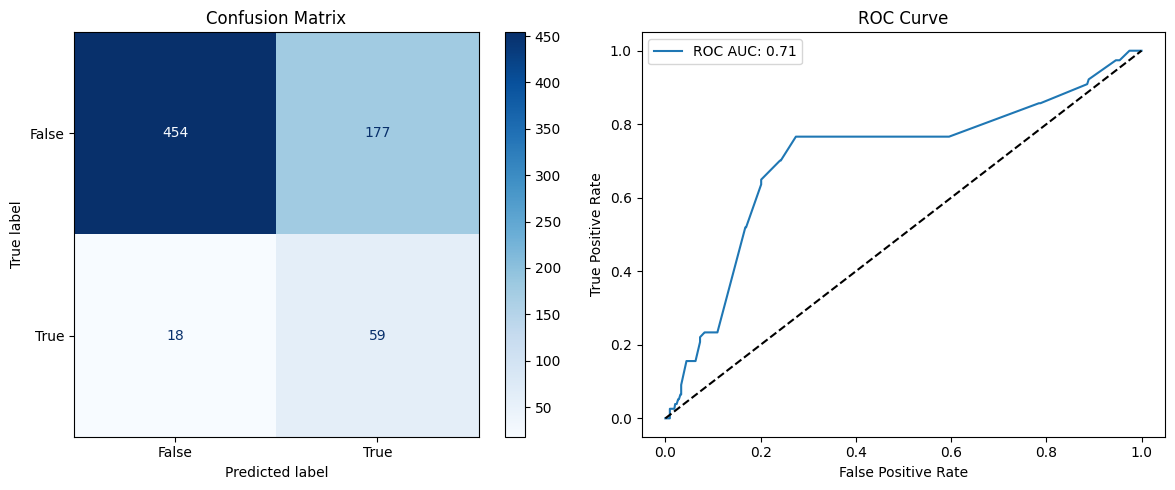

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, ConfusionMatrixDisplay, roc_curve, classification_report
import matplotlib.pyplot as plt

# Quick Model Metric Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].set_title("ROC Curve")

plt.tight_layout()
plt.show()

## Create ML API endpoint and Score Prospects

### Create and serve an API endpoint

For simplicity we use free TryCloudflare tunnels to expose this Colab notebook behind an HTTPS endpoint.

When this cell runs, you should see your URL like `https://abc-123.trycloudflare.com` in the output.


In [13]:
%pip install flask-cloudflared

In [14]:
from flask import Flask, request
from flask_cloudflared import run_with_cloudflared

# Define and launch Colab API Proxy
app = Flask(__name__)
run_with_cloudflared(app) # Open Cloudflared demo tunnel

# Load model
model = joblib.load("model.joblib")

# Process the Signals data for individual domain_userids
def get_duid_values(duid: str):
    # Retrieve attributes from Signals
    response = sp_signals.get_service_attributes(
        name="prospect_scoring_tutorial_service",
        attribute_key="domain_userid",
        identifier=duid,
    )
    signals_df = pd.DataFrame([response])
    # Prepare ML dataframe
    ml_df = signals_df.fillna(0).reindex(columns=x_columns, fill_value=0)
    return (signals_df, ml_df)

# Score the data against the model
def get_predictions(df):
    return float(model.predict_proba(df)[:, 1][0])

@app.route("/predict", methods=['POST'])
def predict():
    input_dict = request.get_json() # Parse JSON input

    # Get Signals data and prepare dataframe for scoring
    signals_df, ml_df = get_duid_values(input_dict['domain_userid'])

    # Score dataframe using the trained model
    prediction = get_predictions(ml_df)

    # Return the result
    print(f"P: {round(prediction, 4)} - {input_dict}")
    return {
        "signals": signals_df.to_dict(orient='records')[0],
        "scoring_attributes": ml_df.to_dict(orient='records')[0],
        "score": prediction
    }

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Downloading cloudflared for Linux x86_64...
 * Running on https://general-came-tells-priced.trycloudflare.com
 * Traffic stats available on http://127.0.0.1:8817/metrics


/tmp/ipython-input-996175435.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ml_df = signals_df.fillna(0).reindex(columns=x_columns, fill_value=0)
INFO:werkzeug:127.0.0.1 - - [03/Nov/2025 23:16:57] "POST /predict HTTP/1.1" 200 -


P: 0.3508 - {'domain_userid': '00000000-1111-2222-3333-444455556666'}


/tmp/ipython-input-996175435.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ml_df = signals_df.fillna(0).reindex(columns=x_columns, fill_value=0)
INFO:werkzeug:127.0.0.1 - - [03/Nov/2025 23:16:59] "POST /predict HTTP/1.1" 200 -


P: 0.3508 - {'domain_userid': '00000000-1111-2222-3333-444455556666'}


### Test using cURL

Verify via cURL, using the ngrok URL and your current `domain_userid` on your website:

```bash
curl -X POST "https://<YOUR_CLOUDFLARED_URL>.trycloudflare.com/predict" \
-H "Content-Type: application/json" \
-d '{"domain_userid": "UPDATE THIS"}'
```

### See scores in the browser

Verify via JS in the browser console:

```js
let api_url = "https://<UPDATE_THIS>.trycloudflare.com/predict"; // UPDATE THIS
let tracker_name = "sp"; // MAYBE UPDATE THIS

// Calls the API every 10s from the front-end
setInterval(function () {
    // assuming the Snowplow tracker is available at 'window.snowplow(...)'
    window.snowplow(function () {
        // Gets domain_userid from the tracker instance
        var sp = this[tracker_name];
        var domainUserId = sp.getDomainUserId();

        // Calls the API
        fetch(api_url, {
            method: "POST",
            headers: { "Content-Type": "application/json" },
            body: JSON.stringify({ domain_userid: domainUserId })
        })
        .then(response => response.json())
        .then(result => {
            console.log("Prediction: ", domainUserId, " - ", result.score);

            // Acts on prediction
            if (result.score >= 0.8) console.log('Prospect is likely to convert!');
        })
        .catch(console.error);
    });
}, 10 * 1000);
```